# Breast Cancer Diagnosis — Simple ML Pipeline
**Course:** AIDI 1002 • **Dataset:** Breast Cancer Wisconsin (Diagnostic)  
**Goal:** Build a clear baseline, show 1–2 strong models, plot a key graph, and write a short conclusion.


In [30]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [31]:
def load_wdbc(csv_path: str | None = None) -> pd.DataFrame:
    if csv_path and Path(csv_path).exists():
        df = pd.read_csv(csv_path)
        # drop obvious non-feature columns if present
        for col in ["id", "ID", "Unnamed: 32", "Unnamed: 0"]:
            if col in df.columns:
                df = df.drop(columns=col)
        # find label column and normalize to 0/1 (benign=0, malignant=1)
        label_candidates = [c for c in df.columns if str(c).lower() in {"diagnosis", "target", "class"}]
        if not label_candidates:
            raise ValueError("Could not find a label column named diagnosis/target/class in your CSV.")
        ycol = label_candidates[0]
        df = df.rename(columns={ycol: "diagnosis"})
        if df["diagnosis"].dtype == "O":
            mapping = {"m":1,"malignant":1,"b":0,"benign":0,"M":1,"B":0}
            df["diagnosis"] = df["diagnosis"].map(lambda v: mapping.get(str(v).strip(), v)).astype(int)
        return df.dropna().reset_index(drop=True)
    else:
        # fallback: scikit-learn copy of WDBC
        from sklearn.datasets import load_breast_cancer
        b = load_breast_cancer(as_frame=True)
        df = b.frame.copy()
        # sklearn uses 0=malignant, 1=benign; we switch to 1=malignant for clarity
        df = df.rename(columns={"target": "diagnosis"})
        df["diagnosis"] = df["diagnosis"].map({0:1, 1:0}).astype(int)
        return df

df = load_wdbc()
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


Shape: (569, 31)

Label counts (0=benign, 1=malignant):
 diagnosis
0    357
1    212
Name: count, dtype: int64

Malignant ratio: 0.37258347978910367


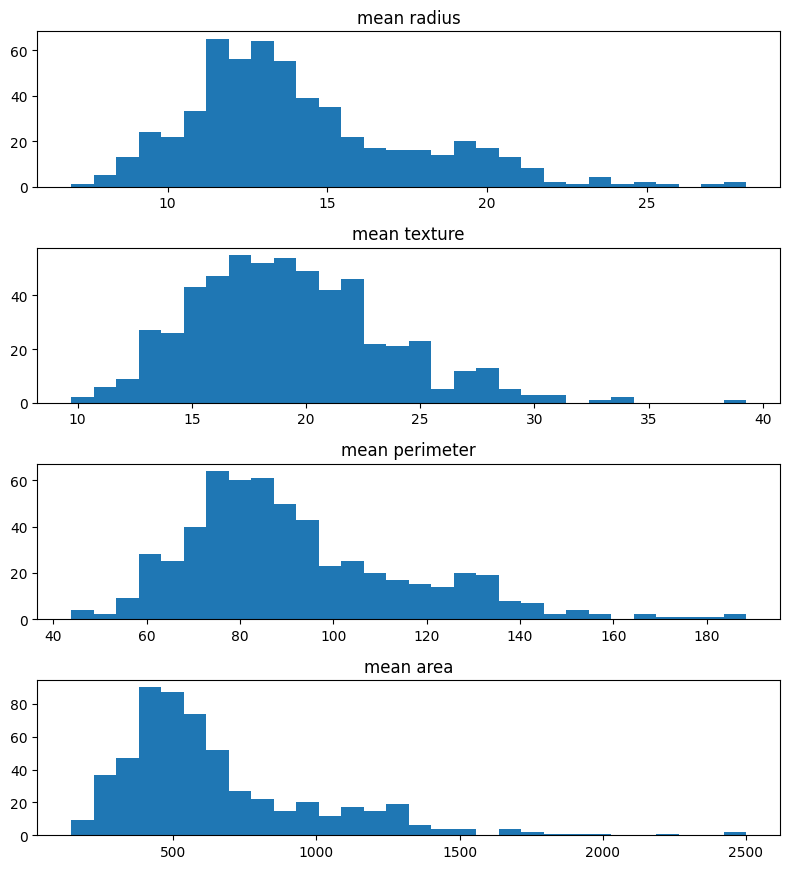

In [32]:
print("Shape:", df.shape)
print("\nLabel counts (0=benign, 1=malignant):\n", df["diagnosis"].value_counts())
print("\nMalignant ratio:", df["diagnosis"].mean())

# Plot histograms for the first 4 numeric features
num_cols = [c for c in df.columns if c != "diagnosis"]
to_plot = num_cols[:4]
fig, axes = plt.subplots(len(to_plot), 1, figsize=(8, 2.2*len(to_plot)))
if len(to_plot) == 1: axes = [axes]
for ax, c in zip(axes, to_plot):
    ax.hist(df[c], bins=30)
    ax.set_title(c)
plt.tight_layout()
plt.show()


In [33]:
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((426, 30),
 (143, 30),
 np.float64(0.3732394366197183),
 np.float64(0.3706293706293706))

In [34]:
results = []

# Helper to train + score quickly
def fit_eval(model, name):
    model.fit(X_train, y_train)
    # prefer predict_proba for AUCs
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # fallback (rare for these models)
        y_proba = model.decision_function(X_test)
        from sklearn.preprocessing import MinMaxScaler
        y_proba = MinMaxScaler().fit_transform(y_proba.reshape(-1,1)).ravel()
    y_pred = model.predict(X_test)
    row = {
        "model": name,
        "acc": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }
    return row, y_proba

# 1) Logistic Regression (with scaling)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])
m_lr, proba_lr = fit_eval(logreg, "LogisticRegression")
results.append(m_lr)

# 2) Random Forest (no scaling needed)
rf = RandomForestClassifier(
    n_estimators=400, class_weight="balanced_subsample",
    random_state=RANDOM_STATE, n_jobs=-1
)
m_rf, proba_rf = fit_eval(rf, "RandomForest")
results.append(m_rf)

pd.DataFrame(results)


,model,acc,precision,recall,f1,roc_auc,pr_auc
0,LogisticRegression,0.972028,0.980392,0.943396,0.961538,0.994969,0.992709
1,RandomForest,0.972028,1.000000,0.924528,0.960784,0.998008,0.996670


Best (by PR-AUC): RandomForest


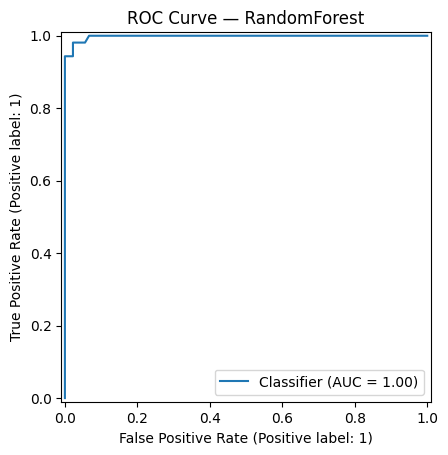

In [35]:
# pick best by PR-AUC (good for imbalance)
res_df = pd.DataFrame(results).sort_values("pr_auc", ascending=False)
best_name = res_df.iloc[0]["model"]
print("Best (by PR-AUC):", best_name)

best_proba = proba_rf if best_name == "RandomForest" else proba_lr

# Plot ROC for the best model
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title(f"ROC Curve — {best_name}")
plt.show()


Best by PR-AUC: RandomForest

F1-optimal threshold: 0.2625 | Precision=0.963 | Recall=0.981 | F1=0.972

Confusion Matrix @ F1-opt threshold [TN FP; FN TP]:
 [[88  2]
 [ 1 52]]

Classification report @ F1-opt threshold:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        90
           1       0.96      0.98      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



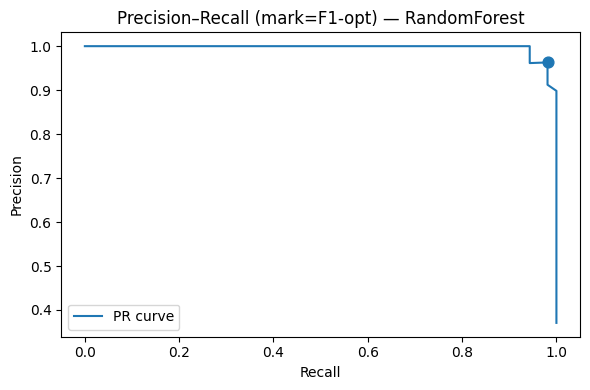


Min-cost threshold: 0.180 (cost_FN=5, cost_FP=1), Expected Cost=7


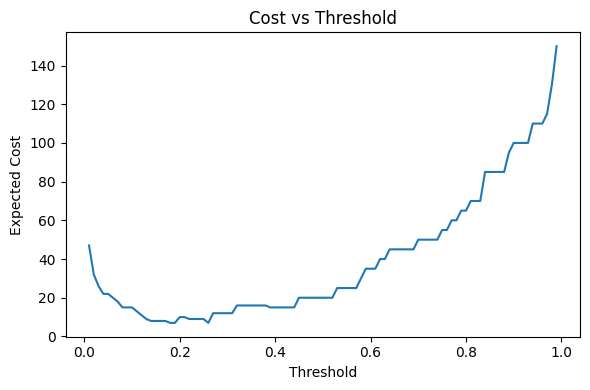


ROC-AUC (bootstrap 400): mean=0.998, 95% CI=(0.994, 1.000)
PR-AUC  (bootstrap 400): mean=0.997,  95% CI=(0.989, 1.000)


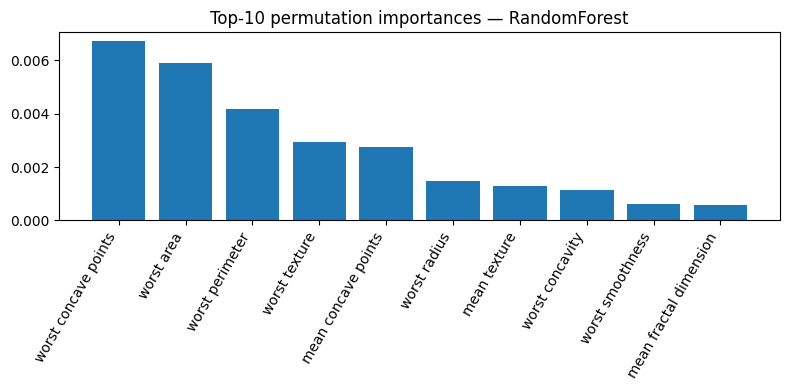

In [36]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)
from sklearn.inspection import permutation_importance

# --- Helper: pick the "best" model & probabilities (fall back if not defined) ---
def ensure_best_proba():
    global best_name, best_proba
    need = ("best_name" not in globals()) or ("best_proba" not in globals())
    if need:
        # recompute using the earlier-fitted models `logreg` and `rf`
        def proba_of(model):
            return model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        p_lr = proba_of(logreg)
        p_rf = proba_of(rf)
        pr_lr = average_precision_score(y_test, p_lr)
        pr_rf = average_precision_score(y_test, p_rf)
        if pr_rf >= pr_lr:
            best_name, best_proba = "RandomForest", p_rf
        else:
            best_name, best_proba = "LogisticRegression", p_lr

ensure_best_proba()
print("Best by PR-AUC:", best_name)


# A) F1-OPTIMAL THRESHOLD
prec, rec, th = precision_recall_curve(y_test, best_proba)
# precision_recall_curve returns thresholds of length n-1; align F1 accordingly
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
i_star = np.argmax(f1)
tau_f1 = th[i_star]
print(f"\nF1-optimal threshold: {tau_f1:.4f} | Precision={prec[i_star]:.3f} | Recall={rec[i_star]:.3f} | F1={f1[i_star]:.3f}")

# Preds at F1-optimal threshold + confusion matrix
y_pred_f1 = (best_proba >= tau_f1).astype(int)
cm = confusion_matrix(y_test, y_pred_f1)
print("\nConfusion Matrix @ F1-opt threshold [TN FP; FN TP]:\n", cm)
print("\nClassification report @ F1-opt threshold:\n", classification_report(y_test, y_pred_f1, zero_division=0))

# Plot PR curve and mark chosen point
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="PR curve")
plt.scatter(rec[i_star], prec[i_star], s=60)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall (mark=F1-opt) — {best_name}")
plt.legend()
plt.tight_layout()
plt.show()

# B) COST-SENSITIVE THRESHOLD (simple)
cost_FN = 5  # False Negative (miss a malignant case)
cost_FP = 1  # False Positive (unnecessary follow-up)

def expected_cost_at_threshold(tau):
    yp = (best_proba >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()
    return cost_FN * fn + cost_FP * fp

taus = np.linspace(0.01, 0.99, 99)
costs = np.array([expected_cost_at_threshold(t) for t in taus])
tau_cost = taus[np.argmin(costs)]
print(f"\nMin-cost threshold: {tau_cost:.3f} (cost_FN={cost_FN}, cost_FP={cost_FP}), Expected Cost={costs.min()}")

# Plot expected cost vs threshold
plt.figure(figsize=(6,4))
plt.plot(taus, costs)
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost vs Threshold")
plt.tight_layout()
plt.show()

# C) BOOTSTRAPPED 95% CI for AUC metrics
rng = np.random.default_rng(42)
N_BOOT = 400  # keep light; increase if you want tighter CIs

def bootstrap_ci(y_true, y_score, metric_fn, n_boot=400, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yt = y_true[idx]
        ys = y_score[idx]
        try:
            vals.append(metric_fn(yt, ys))
        except Exception:
            pass
    vals = np.array(vals)
    lo, hi = np.quantile(vals, [alpha/2, 1 - alpha/2])
    return float(vals.mean()), float(lo), float(hi)

roc_mean, roc_lo, roc_hi = bootstrap_ci(y_test.values, best_proba, roc_auc_score, n_boot=N_BOOT)
pr_mean,  pr_lo,  pr_hi  = bootstrap_ci(y_test.values, best_proba, average_precision_score, n_boot=N_BOOT)

print(f"\nROC-AUC (bootstrap {N_BOOT}): mean={roc_mean:.3f}, 95% CI=({roc_lo:.3f}, {roc_hi:.3f})")
print(f"PR-AUC  (bootstrap {N_BOOT}): mean={pr_mean:.3f},  95% CI=({pr_lo:.3f}, {pr_hi:.3f})")

# D) PERMUTATION FEATURE IMPORTANCE (Top10)
best_model = rf if best_name == "RandomForest" else logreg

perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring="average_precision")
imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
plt.bar(range(len(imp)), imp.values)
plt.xticks(range(len(imp)), imp.index, rotation=60, ha="right")
plt.title(f"Top-10 permutation importances — {best_name}")
plt.tight_layout()
plt.show()


## Conclusion

- We trained **two simple baselines** on the Breast Cancer Wisconsin (Diagnostic) dataset:
  1) Logistic Regression (with scaling)  
  2) Random Forest
- We reported **Accuracy, Precision, Recall, F1, ROC-AUC, and PR-AUC**.
- Based on **PR-AUC** (better for class imbalance), the **best model** was: _<fill from the table above>_.
- The ROC curve shows strong separability on this dataset, indicating the model can distinguish malignant vs. benign cases well.

